# Linear regression with iterative optimization: `SGDRegressor`
In this notebook, we will build linear regression model with `SGDRegressor`. SGD offers a lot of control over optimization procedure through a number of hyperparameters. However, we need to set them to right values in order to make it work for training the model.


In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
np.random.seed(306)

In [4]:
# We will use ShuffleSplit as a cross validation strategy.
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=10)

In [5]:
# Let's load the data and split it into training and test.
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
com_train_features, test_features, com_train_labels, test_labels = train_test_split(
    features, labels, random_state=42
)

In [6]:
# Divide the data into train and dev sets.
train_features, dev_features, train_labels, dev_labels = train_test_split(
    com_train_features, com_train_labels, random_state=42
)

## Baseline `SGDRegressor`
1. To begin with, we instantiate a baseline `SGDRegressor` model with default parameters.
2. Train the model with training feature matrix and labels.
3. Obtain the score on the training data and dev data.

In [7]:
sgd = SGDRegressor(random_state=42)
sgd.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd.predict(dev_features))
print('Mean absolute error on Training set: ', train_mae)
print('Mean absolute error on development set: ', dev_mae)

Mean absolute error on Training set:  335010457582554.3
Mean absolute error on development set:  338216494599083.75


We can observe that the mean absolute error is too high. The baseline model does not train well. This may happen due to large learning rate.  
Let's investigate this issue by training the model step by step and recording training loss in each step.

## Adding a feautre scaling step
SGD is sensitive to feature scaling. Let's add a feature scaling step and check if we get better MAE.

In [8]:
sgd_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                            ('sgd', SGDRegressor())])
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print('Mean absolute error on Training set: ', train_mae)
print('Mean absolute error on development set: ', dev_mae)

Mean absolute error on Training set:  0.5135804404077053
Mean absolute error on development set:  0.6373131245753219


The error is still high, let's run `SGDRegressor` step by step and investicate issues with training.

## Step-wise training of `SGDRegressor`
1. Instantiate `SGDRegressor` with `warm_start=True` and `tol=-np.infty`.
2. Train SGD step by step and record regression loss in each step.
3. Plot learning curves and see if there are any issues in training.


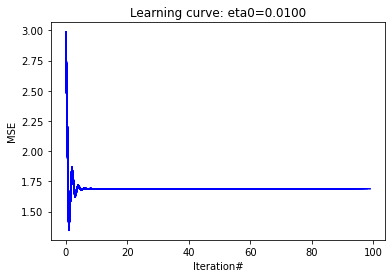

In [9]:
eta0 = 1e-2
sgd_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                            ('SGD', SGDRegressor(max_iter=1, tol=-np.infty,
                                                    warm_start=True,
                                                    random_state=42))])
loss = []
for epoch in range(100):
    sgd_pipeline.fit(train_features, train_labels)  # continues where it left off
    loss.append(mean_squared_error(train_labels, sgd_pipeline.predict(train_features)))
    plt.plot(np.arange(len(loss)), loss, 'b-')
    plt.xlabel('Iteration#')
    plt.ylabel('MSE')
    plt.title(f'Learning curve: eta0={eta0:.4f}')

The loss reduced initially and then increased. This could be due to large learning rates. We will reduce the learning rate by a factor of 10 and retry the training.

Text(0.5, 1.0, 'Learning curve: eta0=0.0010')

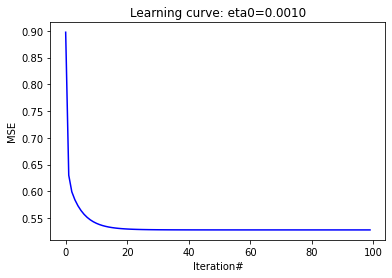

In [10]:
eta0 = 1e-3
sgd_pipeline = Pipeline([('feature_sclaing', StandardScaler()),
                        ('SGD', SGDRegressor(max_iter=1, tol=-np.infty,
                                            warm_start=True, eta0=eta0,
                                            random_state=42))])
loss = []
for epoch in range(100):
    sgd_pipeline.fit(train_features, train_labels)  # continues where it left off
    loss.append(mean_squared_error(train_labels, sgd_pipeline.predict(train_features)))

plt.plot(np.arange(len(loss)), loss, '-b')
plt.xlabel('Iteration#')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0:.4f}')

This is an ideal learning curve where the train loss reduces monotonically as the training progresses.

In [11]:
print('#iteration before reaching convergence criteria:', sgd_pipeline[-1].n_iter_)
print('#weight updates: ', sgd_pipeline[-1].t_)

#iteration before reaching convergence criteria: 1
#weight updates:  11611.0


In [15]:
train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print('Mean absolute error on Training set: ', train_mae)
print('Mean absolute error on development set: ', dev_mae)

Mean absolute error on Training set:  0.5333732983042573
Mean absolute error on development set:  0.5190150280908042


## Fixing learning rate through validation curves
1. Provide the list of values to be tried for a hyper-parameter.
2. Instantiate an object of `validation_curve` with estimator, training features and label, Set `scoring` parameter to relavent score.
3. Convert scores to error
4. Plot validation curve with the value of hyper-parameter on x-axis and error on the y-axis.
5. Fix the hyper-parameter value where the test error is the least.

In [17]:
%%time
eta0 = [1e-5, 1e-4, 1e-3, 1e-2]
train_scores, test_scores = validation_curve(
    sgd_pipeline, com_train_features, com_train_labels, param_name='SGD__eta0',
    param_range=eta0, cv=shuffle_split_cv, scoring='neg_mean_squared_error',
    n_jobs=2
)

CPU times: user 67.1 ms, sys: 29.9 ms, total: 97.1 ms
Wall time: 216 ms


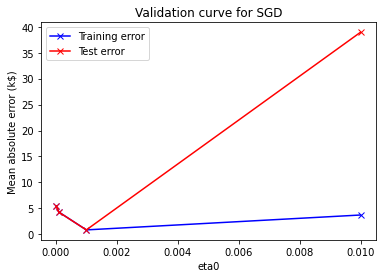

In [22]:
train_errors, test_errors = -train_scores, -test_scores
plt.plot(eta0, train_errors.mean(axis=1), 'b-x', label='Training error')
plt.plot(eta0, test_errors.mean(axis=1), 'r-x', label='Test error')
plt.legend()

plt.xlabel('eta0')
plt.ylabel('Mean absolute error (k$)')
_ = plt.title('Validation curve for SGD')
# plt.axis([0, 0.01, 0, 10])

For `eta0=1e-3`, the test error is the least and hence we select that value as the value for `eta0`.  
Next we also plot standard deviation in errors.

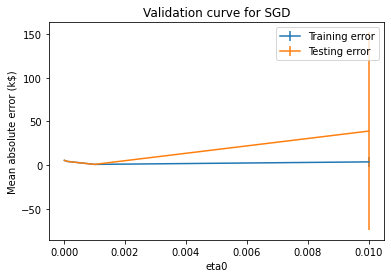

In [23]:
plt.errorbar(eta0, train_errors.mean(axis=1),
            yerr=train_errors.std(axis=1), label='Training error')
plt.errorbar(eta0, test_errors.mean(axis=1),
            yerr=test_errors.std(axis=1), label='Testing error')
plt.legend()

plt.xlabel('eta0')
plt.ylabel('Mean absolute error (k$)')
_ = plt.title('Validation curve for SGD')

### `SGDRegressor`

In [25]:
sgd_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                        ('sgd', SGDRegressor(max_iter=500,
                                            early_stopping=True,
                                            eta0=1e-3,
                                            tol=1e-3,
                                            validation_fraction=0.2,
                                            n_iter_no_change=5,
                                            average=10,
                                            random_state=42)
                        )])
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print('Mean absolute error on Training set: ', train_mae)
print('Mean absolute error on development set: ', dev_mae)

Mean absolute error on Training set:  0.579376454514559
Mean absolute error on development set:  0.5689180241137523


In [26]:
print('Number of SGD iterations: ', sgd_pipeline[-1].n_iter_)
print('Number of weight updates: ', sgd_pipeline[-1].t_)

Number of SGD iterations:  7
Number of weight updates:  81271.0


In [28]:
sgd_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                        ('sgd', SGDRegressor(max_iter=500,
                                            early_stopping=True,
                                            eta0=1e-3,
                                            tol=1e-3,
                                            learning_rate='constant',
                                            validation_fraction=0.2,
                                            n_iter_no_change=5,
                                            average=10,
                                            random_state=42)
                        )])
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print('Mean absolute error on Training set: ', train_mae)
print('Mean absolute error on development set: ', dev_mae)

print('Number of SGD iterations: ', sgd_pipeline[-1].n_iter_)
print('Number of weight updates: ', sgd_pipeline[-1].t_)

Mean absolute error on Training set:  0.5359339681114987
Mean absolute error on development set:  0.5151099728924144
Number of SGD iterations:  8
Number of weight updates:  92881.0


In [29]:
sgd_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                        ('sgd', SGDRegressor(max_iter=500,
                                            early_stopping=True,
                                            eta0=1e-3,
                                            tol=1e-3,
                                            learning_rate='adaptive',
                                            validation_fraction=0.2,
                                            n_iter_no_change=5,
                                            average=10,
                                            random_state=42)
                        )])
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print('Mean absolute error on Training set: ', train_mae)
print('Mean absolute error on development set: ', dev_mae)

print('Number of SGD iterations: ', sgd_pipeline[-1].n_iter_)
print('Number of weight updates: ', sgd_pipeline[-1].t_)

Mean absolute error on Training set:  0.5340193046836148
Mean absolute error on development set:  0.5198356196858102
Number of SGD iterations:  33
Number of weight updates:  383131.0


## Setting `max_iters`

In [31]:
max_iter = np.ceil(1e6/com_train_features.shape[0])
max_iter

65.0

In [32]:
sgd_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                        ('sgd', SGDRegressor(max_iter=max_iter,
                                            early_stopping=True,
                                            eta0=1e-3,
                                            tol=1e-3,
                                            learning_rate='constant',
                                            validation_fraction=0.2,
                                            n_iter_no_change=5,
                                            average=10,
                                            random_state=42)
                        )])
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print('Mean absolute error on Training set: ', train_mae)
print('Mean absolute error on development set: ', dev_mae)

print('Number of SGD iterations: ', sgd_pipeline[-1].n_iter_)
print('Number of weight updates: ', sgd_pipeline[-1].t_)

Mean absolute error on Training set:  0.5359339681114987
Mean absolute error on development set:  0.5151099728924144
Number of SGD iterations:  8
Number of weight updates:  92881.0


## Summary
In this notebook, we saw:
- how to build `SGDRegressor` model.
- how to tune the learning rate.
- how to use different `leaning_rate`s and their impact on convergence.
- how to euse early stopping and averaged SGD.
- how to tune hyperparameters with validation curves.